In [1]:
import pandas as pd

In [2]:
df1 = pd.read_parquet('C:/Users/86138/Tigercut/midterm/train.parquet')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

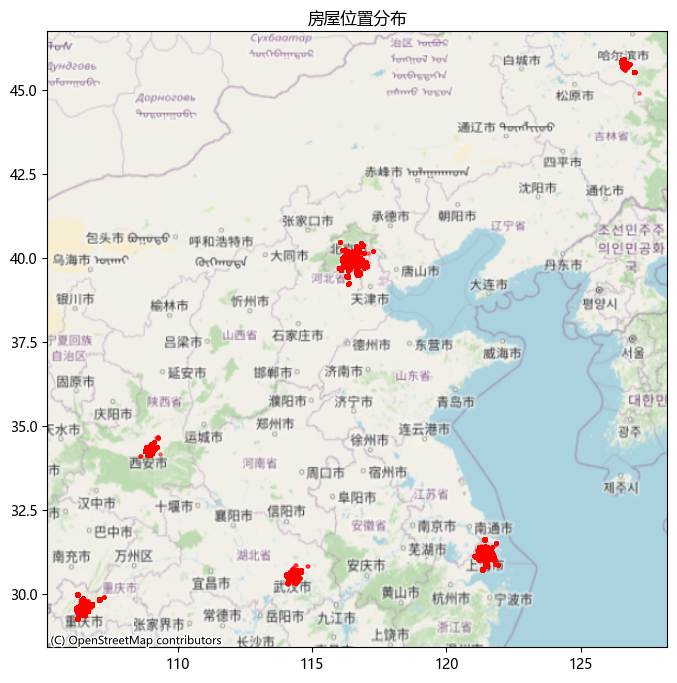

In [4]:
# 地图叠加
def plot_with_map(df1):
    # 创建图形
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(df1["lon"], df1["lat"], s=5, c="red", alpha=0.5)

    # 使用OpenStreetMap作为底图（替代Stamen）
    try:
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs="EPSG:4326")
    except Exception as e:
        print(f"地图加载失败: {e}")
        print("尝试使用CartoDB地图...")
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs="EPSG:4326")

    plt.title("房屋位置分布")
    plt.show()

plot_with_map(df1)

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84133 entries, 0 to 84132
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   城市      84133 non-null  int64  
 1   区域      84133 non-null  float64
 2   板块      84133 non-null  float64
 3   环线      42726 non-null  object 
 4   小区名称    84133 non-null  object 
 5   价格      84133 non-null  int64  
 6   房屋户型    83528 non-null  object 
 7   所在楼层    84133 non-null  object 
 8   建筑面积    84133 non-null  object 
 9   套内面积    25146 non-null  object 
 10  房屋朝向    84133 non-null  object 
 11  建筑结构    83528 non-null  object 
 12  装修情况    83528 non-null  object 
 13  梯户比例    82438 non-null  object 
 14  配备电梯    75818 non-null  object 
 15  别墅类型    749 non-null    object 
 16  交易时间    84133 non-null  object 
 17  交易权属    84133 non-null  object 
 18  上次交易    55180 non-null  object 
 19  房屋用途    84131 non-null  object 
 20  房屋年限    54351 non-null  object 
 21  产权所属    84133 non-null  object 
 22

In [6]:
df1['城市'] = df1['城市'].astype('category')
df1['区域'] = df1['区域'].astype('category')
df1['板块'] = df1['板块'].astype('category')

# 环线

In [8]:
df1['环线'].value_counts()

环线
二至三环     8994
内环内      8976
五至六环     5573
三至四环     4453
四至五环     2785
三环外      2197
外环外      2038
六环外      1927
一至二环     1864
内环至外环    1044
中环至外环     923
内环至中环     892
二环内       603
一环内       347
四环外       110
Name: count, dtype: int64

In [9]:
# 1. 数据预处理
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# 提取关键特征
geo_data = df1[['lon', 'lat']].copy()
target = df1['环线'].copy()

# 将环线转换为数值编码
le = LabelEncoder()
target_encoded = le.fit_transform(target.dropna())

# 分离已知和未知数据
known_idx = target[target.notna()].index
unknown_idx = target[target.isna()].index

X_train = geo_data.loc[known_idx].values
y_train = target_encoded
X_predict = geo_data.loc[unknown_idx].values

# 2. 构建KNN模型
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_predict_scaled = scaler.transform(X_predict)

# 通过交叉验证选择最佳K值
from sklearn.model_selection import cross_val_score

k_range = range(3, 15)
cv_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

best_k = k_range[np.argmax(cv_scores)]
print(f"最优K值: {best_k}")

# 训练最终模型
knn = KNeighborsClassifier(n_neighbors=best_k, weights='distance')  # 使用正确类名
knn.fit(X_train_scaled, y_train)

# 3. 预测与结果合并
predicted_labels = knn.predict(X_predict_scaled)
predicted_ring = le.inverse_transform(predicted_labels)

df1.loc[unknown_idx, '环线'] = predicted_ring

print("\n填补后环线分布:")
print(df1['环线'].value_counts(dropna=False))

最优K值: 3

填补后环线分布:
环线
内环内      20661
六环外      17495
二至三环     13369
五至六环      6181
三至四环      4925
三环外       4501
内环至外环     3772
外环外       3382
一至二环      3380
四至五环      2848
中环至外环      938
内环至中环      907
一环内        773
二环内        603
四环外        398
Name: count, dtype: int64


In [10]:
from sklearn.model_selection import train_test_split

# 从已知数据中拆分训练集和测试集（比例通常为7:3或8:2）
X_train, X_test, y_train, y_test = train_test_split(
    geo_data.loc[known_idx].values,
    target_encoded,
    test_size=0.3,
    random_state=42,
    stratify=target_encoded  # 保持类别比例
)

# 训练模型（使用之前确定的最佳K值）
knn = KNeighborsClassifier(n_neighbors=best_k, weights='distance')
knn.fit(scaler.transform(X_train), y_train)

# 在测试集上评估
test_acc = knn.score(scaler.transform(X_test), y_test)
print(f"测试集准确率: {test_acc:.2%}")

# 输出分类报告
from sklearn.metrics import classification_report
print(classification_report(
    y_test,
    knn.predict(scaler.transform(X_test)),
    target_names=le.classes_
))

测试集准确率: 99.94%
              precision    recall  f1-score   support

         一环内       0.99      0.99      0.99       104
        一至二环       1.00      1.00      1.00       559
         三环外       1.00      1.00      1.00       659
        三至四环       1.00      1.00      1.00      1336
       中环至外环       1.00      1.00      1.00       277
         二环内       1.00      1.00      1.00       181
        二至三环       1.00      1.00      1.00      2698
        五至六环       1.00      1.00      1.00      1672
         六环外       1.00      1.00      1.00       578
         内环内       1.00      1.00      1.00      2693
       内环至中环       1.00      1.00      1.00       268
       内环至外环       1.00      1.00      1.00       313
         四环外       1.00      1.00      1.00        33
        四至五环       1.00      1.00      1.00       836
         外环外       1.00      1.00      1.00       611

    accuracy                           1.00     12818
   macro avg       1.00      1.00      1.00     12818
weighted av

In [11]:
df1['环线'] = df1['环线'].astype('category')

# 室厅厨卫

In [12]:
# 灵活的正则表达式（允许部分缺失）
pattern = r'(?:(?P<室>\d+)(?:室|房间))?(?:(?P<厅>\d+)厅)?(?:(?P<厨>\d+)厨)?(?:(?P<卫>\d+)卫)?'
extracted = df1["房屋户型"].str.extract(pattern)

for col in ["室", "厅", "厨", "卫"]:
    df1[col] = pd.to_numeric(extracted[col], errors="coerce").astype('Int32')

In [13]:
df1[["室", "厅", "厨", "卫"]].describe()

,室,厅,厨,卫
count,83528.0,82819.0,82819.0,83528.0
mean,2.455955,1.413649,0.997187,1.380615
std,0.958874,0.590719,0.130219,0.637196
min,0.0,0.0,0.0,0.0
25%,2.0,1.0,1.0,1.0
50%,2.0,1.0,1.0,1.0
75%,3.0,2.0,1.0,2.0
max,16.0,7.0,5.0,14.0


In [14]:
# 缺失值填充
df1["室"] = df1["室"].fillna(2)
df1["厅"] = df1.apply(lambda x: x["厅"] if pd.notna(x["厅"]) else 2 if x["室"]>=3 else 1, axis=1)
df1["厨"] = df1["厨"].fillna(1)
df1["卫"] = df1.apply(lambda x: x["卫"] if pd.notna(x["卫"]) else max(1, x["室"]-1), axis=1)

# 楼层

In [15]:
# 1. 提取相对楼层
df1["相对楼层"] = df1["所在楼层"].str.extract(r"(低楼层|中楼层|高楼层|顶层|底层|地下室)").astype('category')

# 2. 提取总楼层（括号内的数字）
df1["总楼层"] = df1["所在楼层"].str.extract(r"共(\d+)层").astype('Int32')

# 使用面积

In [16]:
area = ['套内面积', '建筑面积']

for col in area:
    df1[col] = df1[col].str.extract(r'(\d+\.?\d*)\s*㎡').astype(float)

In [17]:
# 创建新列（取两者较小值）
df1['使用面积'] = df1[['建筑面积', '套内面积']].min(axis=1)

# 朝向

In [18]:
directions = ['东', '南', '西', '北', '东南', '东北', '西南', '西北']

for direction in directions:
    df1[f'has_{direction}'] = df1['房屋朝向'].str.contains(direction).astype(int)

# 结构与装修

In [19]:
df1["建筑结构"] = df1["建筑结构"].fillna('未知结构').astype('category')

In [20]:
df1["装修情况"] = df1["装修情况"].fillna('其他').astype('category')

# 梯数

In [21]:
import re

# 中文数字到阿拉伯数字的映射字典
chinese_to_arabic = {
    '一': 1, '二': 2, '三': 3, '四': 4, '五': 5,
    '六': 6, '七': 7, '八': 8, '九': 9, '十': 10,
    '两': 2, '零': 0
}

def chinese_to_number(chinese_str):
    """将中文数字转换为阿拉伯数字"""
    if chinese_str.isdigit():  # 已经是数字
        return int(chinese_str)
    
    total = 0
    current = 0
    for char in chinese_str:
        if char in chinese_to_arabic:
            num = chinese_to_arabic[char]
            if num == 10:  # 处理"十"
                total += current * 10 if current != 0 else 10
                current = 0
            else:
                current += num
        else:
            continue
    total += current
    return total

def split_elevator_ratio(ratio_str):
    """拆分梯户比例"""
    # 使用正则表达式匹配模式
    match = re.search(r'([一二两三四五六七八九十\d]+)梯([一二两三四五六七八九十\d]+)户', str(ratio_str))
    if match:
        elevators = match.group(1)  # 梯数部分
        households = match.group(2)  # 户数部分
        
        # 转换为阿拉伯数字
        elevators_num = chinese_to_number(elevators)
        households_num = chinese_to_number(households)
        
        return pd.Series([elevators_num, households_num])
    return pd.Series([None, None])

# 应用函数拆分列
df1[['梯数', '户数']] = df1['梯户比例'].apply(split_elevator_ratio)

In [22]:
df1['elevators_per_household'] = np.where(
    # 条件1：明确有电梯 -> 计算梯户比
    (df1['配备电梯'] == '有') & df1['梯数'].notna() & df1['户数'].notna(),
    df1['梯数'] / df1['户数'],
    np.where(
        # 条件2：明确无电梯 -> 设为0
        df1['配备电梯'] == '无',
        0,
        np.where(
            # 条件3：电梯状态未知但梯数存在 -> 用梯数判断
            df1['梯数'].notna(),
            np.where(df1['梯数'] > 0, df1['梯数'] / df1['户数'], 0),
            np.nan  # 梯数户数均为空时返回NaN
        )
    )
)

# 将最终结果中的空值填充为0
df1['elevators_per_household'] = df1['elevators_per_household'].fillna(0)

# 验证计算结果
print("梯户比分布统计:")
print(df1['elevators_per_household'].describe())

梯户比分布统计:
count    84133.000000
mean         0.347711
std          0.407979
min          0.000000
25%          0.142857
50%          0.333333
75%          0.500000
max         20.000000
Name: elevators_per_household, dtype: float64


# 别墅和户数

In [23]:
df1['房屋用途'].value_counts()

房屋用途
普通住宅      79853
商业办公类      1178
别墅         1064
商住两用       1025
车库          605
公寓          160
写字楼          76
底商           49
商业           45
酒店式公寓        42
公寓/公寓        13
公寓/住宅         7
新式里弄          4
四合院           3
公寓（住宅）        2
老公寓           2
住宅式公寓         1
平房            1
花园洋房          1
Name: count, dtype: int64

In [24]:
df1['房屋用途'] = df1['房屋用途'].fillna('未知').astype('category')

In [25]:
# 筛选别墅用途的房产
villa_properties = df1[df1['房屋用途'] == '别墅'].copy()

# 检查别墅类型分布
villa_type_dist = villa_properties['别墅类型'].value_counts(dropna=False)

print("别墅用途的房产类型分布：")
print(villa_type_dist)

别墅用途的房产类型分布：
别墅类型
联排      455
None    315
叠拼      175
独栋       76
双拼       43
Name: count, dtype: int64


In [26]:
# 标识需要填充的记录
villa_mask = (df1['房屋用途'] == '别墅') & (df1['别墅类型'].isna())

# 填充空值为"普通"
df1.loc[villa_mask, '别墅类型'] = '普通'

In [27]:
# 1. 缺失值填充为"非别墅"
df1['别墅类型'] = df1['别墅类型'].fillna('非别墅')

# 2. 转换为category类型
df1['别墅类型'] = df1['别墅类型'].astype('category')

In [28]:
df1['别墅类型'].value_counts()

别墅类型
非别墅    83069
联排       455
普通       315
叠拼       175
独栋        76
双拼        43
Name: count, dtype: int64

In [29]:
villa_data = df1[df1['别墅类型'] != '非别墅'].copy()
print(f"别墅类记录数量：{len(villa_data)}条")

print("\n别墅类户数描述统计：")
print(villa_data['户数'].describe())

别墅类记录数量：1064条

别墅类户数描述统计：
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: 户数, dtype: float64


In [30]:
villa_mask = df1['别墅类型'] != '非别墅'
df1.loc[villa_mask, '户数'] = 0

In [31]:
df1['户数'].value_counts()

户数
2.0     19811
4.0     15428
3.0     10696
6.0      8443
8.0      6669
        ...  
50.0        2
61.0        1
81.0        1
45.0        1
40.0        1
Name: count, Length: 62, dtype: int64

In [32]:
df1['户数'] = df1['户数'].fillna(4)

# 时间变量

In [33]:
timestamp_cols = ['交易时间', '上次交易']
df1[timestamp_cols] = df1[timestamp_cols].apply(pd.to_datetime, errors='coerce')

In [34]:
# 计算时间差（单位：天）
df1['距上次交易'] = (df1['交易时间'] - df1['上次交易']).dt.days

# 处理缺失值：上次交易为空的设为0
df1['距上次交易'] = df1['距上次交易'].fillna(0).astype(int)

# 分类变量

In [35]:
df1[['交易权属']].value_counts()

交易权属   
商品房        77866
已购公房        2511
拆迁还建房        798
二类经济适用房      579
经济适用房        462
一类经济适用房      397
动迁安置房        341
限价商品房        263
私产           231
集资房          227
央产房          155
房改房          135
定向安置房         55
使用权           51
售后公房          37
自住型商品房        25
Name: count, dtype: int64

In [36]:
df1[['交易权属']] = df1[['交易权属']].astype('category')

In [37]:
df1[['房屋年限']].value_counts()

房屋年限
满五年     29723
满两年     16120
未满两年     8508
Name: count, dtype: int64

In [38]:
df1['房屋年限'] = df1['房屋年限'].fillna('未知').astype('category')

In [39]:
df1[['产权所属']].value_counts()

产权所属
非共有     70207
共有      13926
Name: count, dtype: int64

In [40]:
df1[['产权所属']] = df1[['产权所属']].astype('category')

In [41]:
df1 = df1.drop(['抵押信息'], axis=1)

# 文本值

In [42]:
df1['房屋优势'].value_counts()

房屋优势
装修              5810
地铁、房本满五年        5212
装修、房本满五年        4850
地铁              4199
地铁、装修、房本满五年     4146
、房本满五年          3700
地铁、             3281
装修、             3053
装修、房本满五年、       2873
装修、房本满两年、       2696
房本满五年           2683
地铁、装修、房本满五年、    2454
装修、房本满两年        2202
地铁、房本满两年        2073
地铁、装修           1991
、               1947
地铁、房本满五年、       1835
、房本满五年、         1771
、房本满两年          1742
地铁、装修、房本满两年     1719
地铁、装修、房本满两年、    1670
地铁、装修、          1503
、房本满两年、         1492
房本满两年           1485
地铁、房本满两年、       1018
房本满五年、           384
房本满两年、           280
Name: count, dtype: int64

In [43]:
# 直接创建二值变量
df1['优势_装修'] = df1['房屋优势'].str.contains('装修').astype('Int32')
df1['优势_地铁'] = df1['房屋优势'].str.contains('地铁').astype('Int32')
df1['优势_满五'] = df1['房屋优势'].str.contains('房本满五年').astype('Int32')
df1['优势_满二'] = df1['房屋优势'].str.contains('房本满两年').astype('Int32')

# 填充缺失值为0
df1[['优势_装修', '优势_地铁', '优势_满五', '优势_满二']] = df1[
    ['优势_装修', '优势_地铁', '优势_满五', '优势_满二']
].fillna(0)

In [44]:
df1 = df1.drop(['户型介绍', '核心卖点'], axis=1)

In [45]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# 预处理缺失值（关键修复步骤）
text_columns = ['周边配套', '交通出行']
df1[text_columns] = df1[text_columns].fillna('')  # 将缺失值替换为空字符串

# 周边配套特征提取
def extract_facilities(text):
    text = str(text)
    return pd.Series({
        '商业配套': int(bool(re.search(r'商场|购物|超市|市场|商圈|商业体|餐饮', text))),
        '教育配套': int(bool(re.search(r'学校|小学|中学|幼儿园|校区|国际学校', text))),
        '医疗配套': int(bool(re.search(r'医院|诊所|卫生所|三甲|医疗', text))),
        '生态配套': int(bool(re.search(r'公园|绿地|生态园', text))),
        '金融配套': int(bool(re.search(r'银行|ATM|支行|分行', text)))
    })

# 交通特征提取
def extract_transport(text):
    text = str(text)
    return pd.Series({
        '地铁线路数': len(re.findall(r'\d+号线', text)),
        '公交线路数': len(re.findall(r'\d+路', text)),
        '主干道数': len(re.findall(r'(?<!出口)([\u4e00-\u9fa5\d]+(?:大道|高速|快速路|国道))', text)),
        '交通枢纽': int(bool(re.search(r'火车站|高铁站|机场|客运站', text)))
    })

# 应用特征提取
df1 = pd.concat([
    df1, 
    df1['周边配套'].apply(extract_facilities),
    df1['交通出行'].apply(extract_transport)
], axis=1)

原始数据量: 84133
过滤后数据量: 83291
异常值数量: 842


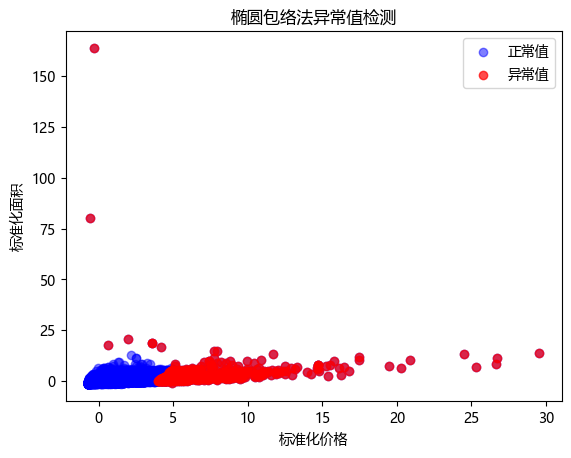

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler

# 提取目标特征
X = df1[['价格', '使用面积']].values

# 标准化数据（椭圆包络对尺度敏感）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 拟合椭圆包络模型
# contamination参数：预期异常值比例（根据数据调整）
envelope = EllipticEnvelope(contamination=0.01, random_state=111)  
envelope.fit(X_scaled)

# 预测异常值（-1表示异常，1表示正常）
outliers = envelope.predict(X_scaled) == -1
df_clean = df1[~outliers]

# 输出结果
print(f"原始数据量: {len(df1)}")
print(f"过滤后数据量: {len(df_clean)}")
print(f"异常值数量: {outliers.sum()}")

# 可视化异常值
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c='blue', label='正常值', alpha=0.5)
plt.scatter(X_scaled[outliers, 0], X_scaled[outliers, 1], c='red', label='异常值', alpha=0.7)
plt.xlabel('标准化价格')
plt.ylabel('标准化面积')
plt.title('椭圆包络法异常值检测')
plt.legend()
plt.show()

In [47]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83291 entries, 0 to 84132
Data columns (total 61 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   城市                       83291 non-null  category      
 1   区域                       83291 non-null  category      
 2   板块                       83291 non-null  category      
 3   环线                       83291 non-null  category      
 4   小区名称                     83291 non-null  object        
 5   价格                       83291 non-null  int64         
 6   房屋户型                     82686 non-null  object        
 7   所在楼层                     83291 non-null  object        
 8   建筑面积                     83291 non-null  float64       
 9   套内面积                     24793 non-null  float64       
 10  房屋朝向                     83291 non-null  object        
 11  建筑结构                     83291 non-null  category      
 12  装修情况                     83291 non-nu

In [48]:
columns_to_keep = [
'城市', '区域', '板块', '环线', '小区名称', '价格', '建筑结构', '装修情况', '别墅类型',
'交易时间', '交易权属', '房屋用途', '房屋年限', '产权所属', 'lon', 'lat', '年份',
'室', '厅', '厨', '卫', '相对楼层', '总楼层', '使用面积', 'has_东', 'has_南',
'has_西', 'has_北', 'has_东南', 'has_东北', 'has_西南', 'has_西北', '户数',
'elevators_per_household', '距上次交易', '优势_装修', '优势_地铁', '优势_满五',
'优势_满二', '商业配套', '教育配套', '医疗配套', '生态配套', '金融配套', '地铁线路数',
'公交线路数', '主干道数', '交通枢纽'
]

cleaned_df = df_clean[columns_to_keep]

In [49]:
cleaned_df.to_parquet(
    path='C:/Users/86138/Tigercut/midterm/train_cleaned.parquet',  # 文件路径
    engine='pyarrow',               # 推荐引擎（支持更全的数据类型）
    compression='snappy',           # 压缩方式（可选：'snappy', 'gzip', 'brotli' 等）
    index=False                      # 不保存索引
)

In [50]:
df_final = pd.read_parquet('C:/Users/86138/Tigercut/midterm/trian_cleaned.parquet')

In [51]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83291 entries, 0 to 83290
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   城市                       83291 non-null  int64         
 1   区域                       83291 non-null  float64       
 2   板块                       83291 non-null  float64       
 3   环线                       83291 non-null  category      
 4   小区名称                     83291 non-null  object        
 5   价格                       83291 non-null  int64         
 6   建筑结构                     83291 non-null  category      
 7   装修情况                     83291 non-null  category      
 8   别墅类型                     83291 non-null  category      
 9   交易时间                     83291 non-null  datetime64[ns]
 10  交易权属                     83291 non-null  category      
 11  房屋用途                     83291 non-null  category      
 12  房屋年限                     83291 n